# waypoints

## define agents

In [10]:
class FGAgent:
    def __init__(self, bubble_r=0.5, lookahead_degrees=[90., 270.], speed=2.0):
        self.bubble_r = bubble_r
        self.lookahead_degrees = lookahead_degrees
        self.speed = speed
        
    def get_action(self, state):
        ranges = state[:360]
        #print(ranges[10], ranges[90], ranges[180], ranges[270], ranges[350])
        beg = int(self.lookahead_degrees[0])
        end = int(self.lookahead_degrees[1])

        ranges = ranges[beg:end]

        ranges = np.clip(ranges, 0, 10.0)
        
        nearest_point = np.min(ranges)
        min_dist = nearest_point + self.bubble_r

        ranges = np.where(ranges <= min_dist, 0.0, ranges)

        gaps = []
        if ranges[0] != 0.0:
            gaps.append(0)

        i = 0
        while i < len(ranges):
            if ranges[i] == 0.0:
                if i > 0:
                    gaps.append(i-1)
                while i < len(ranges) and ranges[i] == 0.0:
                    i += 1
                if i < len(ranges):
                    gaps.append(i)
                continue

            i += 1

        if ranges[-1] != 0.0:
            gaps.append(len(ranges) - 1)

        assert len(gaps) % 2 == 0

        max_gap = -1
        gap_beg = 0
        gap_end = 360

        # find max gap
        i = 0
        while i < len(gaps):
            if gaps[i+1]-gaps[i] > max_gap:
                max_gap = gaps[i+1]-gaps[i]
                gap_beg = gaps[i]+beg
                gap_end = gaps[i+1]+beg
            i += 2

        mid_point = float(gap_end+gap_beg)/2.
        angle_deg = mid_point - 180
        angle_rad = angle_deg * (np.pi/180.)
#         print(f"midpoint:{mid_point}")
        angle = angle_rad * 1.0
        return [angle, self.speed]



In [13]:
import gym
import numpy as np
import time
import yaml
import gym
import numpy as np
from argparse import Namespace

    
class WPEnv(gym.Env):
    
    def __init__(self, map_name='', begin_pos=None):
        self.map_name = map_name
        self.begin_pos = begin_pos
        self.reset()
        
  
    def reset(self):
        def render_callback(env_renderer):
            # custom extra drawing function
            
            e = env_renderer

            # update camera to follow car
            x = e.cars[0].vertices[::2]
            y = e.cars[0].vertices[1::2]
            top, bottom, left, right = max(y), min(y), min(x), max(x)
            e.score_label.x = left
            e.score_label.y = top - 700
            e.left = left - 800
            e.right = right + 800
            e.top = top + 800
            e.bottom = bottom - 800
            
        map_path = f"../maps/{self.map_name}"
        
        self.env = gym.make('f110_gym:f110-v0', map=map_path, map_ext='.png', num_agents=1)
        self.env.add_render_callback(render_callback)
        
        begin_pos = [0, 0, 0] if self.begin_pos is None else self.begin_pos
        obs, step_reward, done, info = self.env.reset(np.array([begin_pos]))
 
        return self.to_vector_state(obs)
    
    def to_vector_state(self, obs):
        
        scanner = np.clip(obs['scans'][0], 0, 10)
        buck = 3
        size = 1080//buck
        agg_scanner = np.zeros(size,)
        for i in range(size):
            agg_scanner[i] = np.mean(scanner[i*buck: i*buck+buck])
                
        state = [
            agg_scanner,
            np.array(obs['linear_vels_x'][0]),
            np.array(obs['ang_vels_z'][0]),
            (obs['poses_x'][0], obs['poses_y'][0], obs['poses_theta'][0])
        ]

        return state
    
        
    def step(self, action):
        act = np.array([action])
        reward = 0
        obs, step_reward, done, info = self.env.step(act)
        
        if obs['collisions'][0] == 1.0:
            print("CRASHED")
            done = True
            reward = -1
        
                
        if obs['lap_counts'][0] == 1.0:
            reward = 1.0
            print("DONE")
            done = True
        
        next_state = self.to_vector_state(obs)
        return next_state, reward, done, info
    
    def render(self):
        self.env.render()

WPEnv(map_name='Oschersleben1')

## create waypoints

In [16]:

done = False
env = WPEnv(map_name='Oschersleben2', begin_pos=[0.0702245, 0.3002981, 2.79787])
obs = env.reset()
agent = FGAgent(speed=2.0)

positions = []

while not done:
    positions.append(obs[3])
    th, v = agent.get_action(obs[0])
    obs, r, done, _ = env.step([th, v])
#     env.render()

DONE


In [21]:
with open('../maps/Oschersleben2-wp.np', 'wb') as f:
    np.save(f, positions)

## analyze waypoints

In [25]:
import numpy as np

with open('../maps/Oschersleben2-wp.np', 'rb') as f:
    wps = np.load(f)
    
dist = np.linalg.norm(wps[0][:2] - wps[117][:2])
print(dist)
print(len(wps))
print(len(wps)//110)

1.8980915183812395
12949
117


In [26]:
from tqdm import tqdm
import gym

map_name = 'Oschersleben2'
env = gym.make('f110_gym:f110-v0', map=f"../maps/{map_name}", map_ext='.png', num_agents=1)

for wp in tqdm(wps):
    obs, step_reward, done, info = env.reset(
        np.array([
            wp
        ])
    )
    if min(obs['scans'][0]) < 0.3:
        print(min(obs['scans'][0]))
        

100%|██████████| 12949/12949 [00:05<00:00, 2254.32it/s]


In [27]:
from scipy.spatial.distance import cdist

x = cdist([[0,0]], wps[:,:2])
np.argmin(x)

12948

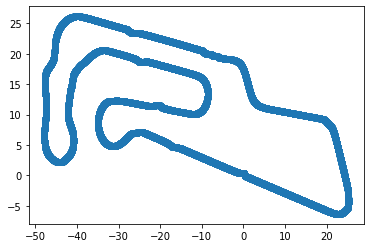

In [28]:
import matplotlib.pyplot as plt

plt.scatter(wps[:,0], wps[:, 1])

# environment

In [25]:
import gym
import numpy as np
import time
import yaml
import gym
import numpy as np
from scipy.spatial.distance import cdist


class F110RaceEnv(gym.Env):
    def __init__(self, env_config,
                 test_map_name=None,
                 scan_range=10.0,
                 max_v=10.0,
                 n_cps = 100,
                 cp_reward = 0.2,
                 min_cp_dist=3.0,
                 maps_path='../maps',
                 models_path='../checkpoints',
                 train_map_name='Oschersleben',
                 safe_padding=0.3,
                 laps = 1.0,
                 min_deg=45,
                 max_deg=315,
                 begin_pos=[0.0702245, 0.3002981, 2.79787]
                ):
        
        self.laps = laps
        self.maps_path = maps_path
        self.observation_space = gym.spaces.Box(low=-np.inf, high=np.inf, shape=(182,), dtype=np.float32)
        self.max_v = max_v
        self.test_map_name = test_map_name
        self.min_cp_dist = min_cp_dist
        self.n_cps = n_cps
        self.cp_reward = cp_reward
        self.scan_range = scan_range
        self.safe_padding = safe_padding
        self.map_path = None
        self.train_map_name = train_map_name
        self.action_space = gym.spaces.Box(low=-1, high=1, shape=(2,), dtype=np.float32)
        self.cum_r = 0
        self.prev_vel = [4.0] * 100
        self.ang_vel_hist = [0.0] * 10
        self.prev_ang_vel = 0.0
        self.total_padding_punish = 0
        self.min_deg = min_deg
        self.max_deg = max_deg
        self.begin_pos = begin_pos
    
    def _render_callback(self, env_renderer):
        # custom extra drawing function

        e = env_renderer

        # update camera to follow car
        x = e.cars[0].vertices[::2]
        y = e.cars[0].vertices[1::2]
        top, bottom, left, right = max(y), min(y), min(x), max(x)
        e.score_label.x = left
        e.score_label.y = top - 700
        e.left = left - 800
        e.right = right + 800
        e.top = top + 800
        e.bottom = bottom - 800
  
    def load_train_setup(self):
        no = np.random.choice([1, 2, 3])
        
        map_path = f"{self.maps_path}/{self.train_map_name}{no}"
        with open(f'{self.maps_path}/Oschersleben{no}-wp.np', 'rb') as f:
            wps = np.load(f)
            
        return map_path, wps
    
    def load_test_setup(self):
        map_path = f"{self.maps_path}/{self.test_map_name}"
        with open(f'{self.maps_path}/Oschersleben1-wp.np', 'rb') as f:
            wps = np.load(f)
            
        return map_path, wps

    def build_checkpoints(self, wps, cp_dist):
        
        start = np.random.randint(0, len(wps)-1)
        checkpoints = []
        
        i = 0
        while i < len(wps):
            if i % cp_dist == 0:
                checkpoints.append(wps[(start+i)%len(wps)])
            i += 1
        return checkpoints
    
    def reset(self):
        self.prev_vel = [3.0] * 100
        self.total_padding_punish = 0
        self.ang_vel_hist = [0.0] * 10
        self.prev_ang_vel = 0.0
        
        self.cum_r = 0
        
        if self.test_map_name is not None:
            map_path, wps = self.load_test_setup()
        else:
            map_path, wps = self.load_train_setup()
        
#         print(map_path, len(wps))
        self.map_path = map_path
        self.env = gym.make('f110_gym:f110-v0', map=map_path, map_ext='.png', num_agents=1)
        self.env.add_render_callback(self._render_callback)
        
        cp_dist = len(wps)//self.n_cps
        
        self.checkpoints = self.build_checkpoints(wps, cp_dist)
#         print(f"number of checkpoints: {len(self.checkpoints)}")
        
        if self.test_map_name is None:
            rotate = np.random.choice([0, np.pi])
            if rotate != 0:
                self.checkpoints = self.checkpoints[::-1]
            start_idx = np.random.randint(0, len(self.checkpoints))
            start_point = self.checkpoints[start_idx]
            start_point[-1] += rotate
            
        else:
            dists = cdist([self.begin_pos[:2]], np.array(self.checkpoints)[:,:2])
            start_idx = np.argmin(dists)
            start_point = self.begin_pos
            
        self.next_cp_idx = (start_idx + 2)%len(self.checkpoints)
            
        
        obs, step_reward, done, info = self.env.reset(
            np.array([
                start_point
            ])
        )
        
        self.t = 0

        return self.to_vector_state(obs)
    
    def to_vector_state(self, obs):
        ranges = obs['scans'][0]
        ranges = ranges[int((self.min_deg/360)*len(ranges)):int((self.max_deg/360)*len(ranges))]
        scanner = np.clip(ranges, 0, self.scan_range)
        
        buck = 3
        size = len(scanner)//buck
        agg_scanner = np.zeros(size,)
        for i in range(size):
            agg_scanner[i] = np.min(scanner[i*buck: i*buck+buck])
        
        #to match gazebo
        agg_scanner = agg_scanner[45:225]
        
        agg_scanner /= self.scan_range
        state = np.concatenate([
            agg_scanner,
            np.array(obs['linear_vels_x'][:1])/self.max_v,
            np.array(obs['ang_vels_z'][:1])/self.max_v,
        ])
        
        if self.test_map_name is None:
            noise = np.random.normal(loc=0.0, scale=0.1, size=state.shape)
            state = state + noise
        return state
    
    def checkpoint(self, position):
        return_cp_idx = (self.next_cp_idx - 5)%len(self.checkpoints)
        return_dist = np.linalg.norm(position - self.checkpoints[return_cp_idx][:2])
        dist = np.linalg.norm(position - self.checkpoints[self.next_cp_idx][:2])
        reward = 0
        if dist < self.min_cp_dist:
            reward = self.cp_reward
            self.next_cp_idx = (self.next_cp_idx + 1)%len(self.checkpoints)
        elif return_dist < 3.0:
            reward = -1
        return reward
        
        
    def step(self, action):
        reward = 0

        act_v = action[0]*(self.max_v/2)+(self.max_v/2)
        self.prev_vel.insert(0, act_v)
        self.prev_vel.pop()
        
        
        th = action[1]*0.34
        act = np.array([[th, act_v]])

        obs, step_reward, done, info = self.env.step(act)
        
        # oscilation neg reward
#         ang_vel = obs['ang_vels_z'][1]
#         diff_ang_vel = abs(ang_vel - self.prev_ang_vel)
#         self.prev_ang_vel = ang_vel
#         self.ang_vel_hist.insert(0, diff_ang_vel)
#         self.ang_vel_hist.pop()
        
        
        pose_x = obs['poses_x'][0]
        pose_y = obs['poses_y'][0]
        
        next_state = self.to_vector_state(obs)
        position = np.array([pose_x, pose_y])

        if obs['collisions'][0] == 1.0:
            reward = -1
            done = True
            if self.test_map_name is not None:
                print('CRASHED')
            return next_state, reward, done, {}
            
        cp_reward = self.checkpoint(position)
        reward += cp_reward
        self.t += 1
        
        finish_time = 100
        if obs['lap_counts'][0] == self.laps:
            t = obs['lap_times'][0]  
#             reward = np.exp(2.5 - 0.05*t)
#             finish_time = t
#             fairlap = 30
#             reward = max(0.2*(fairlap - t), self.cp_reward)
            #print(f"agent on {self.map_path} got reward {self.cum_r} in {t}. Finish reward: {reward}. Padding punish: {self.total_padding_punish}")
            done = True
        elif cp_reward == -1:
            t = obs['lap_times'][0]
            #print(f"agent on {self.map_path} got reward {self.cum_r} in {t}. RETURNED")
            done = True
        elif np.max(self.prev_vel)<3.0:
            t = obs['lap_times'][0]
            #print(f"agent on {self.map_path} got reward {self.cum_r} in {t}. STOPPED")
            reward = -1
            done = True
        
        if done and self.test_map_name is not None:
            print('lap:', obs['lap_times'])
        
        if np.min(obs['scans'][0]) < self.safe_padding:
            reward += -0.05
            self.total_padding_punish -= 0.05
        
        self.cum_r += reward
        return next_state, reward, done, {'pos': position, 'finish_time': finish_time}
    
    def render(self):
        self.env.render()

e = F110RaceEnv({})
e.reset().shape

(182,)

# training

In [26]:
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_VISIBLE_DEVICES=0


In [27]:
#!rm -rf ../checkpoints/phy_v1.0.5/

In [28]:
%%time

import ray
from ray.rllib.agents import ppo
from ray.rllib.agents.ppo.ppo import DEFAULT_CONFIG

ray.shutdown()
ray.init()



# with half cheeta configs

hc_configs = {
    'framework': 'torch',
    'num_workers': 15,
    'gamma': 0.99,
    'num_gpus': 1.0,
    'kl_coeff': 1.0,
    'clip_param': 0.2,
    'model': {
        'fcnet_hiddens': [300, 300],
    },
    'num_envs_per_worker': 1,
    'train_batch_size': 100000,
    'sgd_minibatch_size': 4096,
    'batch_mode': 'truncate_episodes',
    'lr': .0003,
    'horizon': 8000
}


trainer = ppo.PPOTrainer(env=F110RaceEnv, config=hc_configs)
# print("FINE TUNING")
trainer.restore('../checkpoints/phy_v2.0.0/checkpoint_000081/checkpoint-81')

print(trainer.config)
rewards = []
eval_rewards = []
best_reward = -100
models_path = '../checkpoints'

import pickle

def evaluate(model, envs, k=2):
    avg_r = []
    for i in range(k):
        env = envs[i%len(envs)]
        done = False
        obs = env.reset()

        r = 0
        while not done:
            action = model.compute_single_action(obs, explore=False)
            obs, reward, done, info = env.step(action)
            r += reward

        avg_r.append(r)

        
    return np.mean(avg_r)


eval_envs = [
    F110RaceEnv({}, test_map_name='Oschersleben_test2', laps=1),
    F110RaceEnv({}, test_map_name='Oschersleben_test1', laps=1),
]

sim_name = 'phy_v2.0.1'

for i in range(200):
    result = trainer.train()
    episode_r = result['episode_reward_mean']
    print(f"episode: {i} reward:{episode_r}")
    rewards.append(episode_r)
    with open(f'{models_path}/{sim_name}_r', 'wb') as f:
        pickle.dump(rewards, f)
        
    if i%5 == 0:
        eval_reward = evaluate(trainer, envs=eval_envs)
        print(f"evaluation reward: {eval_reward}")
        eval_rewards.append(eval_reward)
        with open(f'{models_path}/{sim_name}_er', 'wb') as f:
            pickle.dump(eval_rewards, f)
#         if episode_r > best_reward:
#             best_reward = episode_r
        cp = trainer.save(f"{models_path}/{sim_name}")
        print("checkpoint saved at", cp)


2022-05-04 11:37:09,086	WARNING ppo.py:223 -- `train_batch_size` (100000) cannot be achieved with your other settings (num_workers=15 num_envs_per_worker=1 rollout_fragment_length=200)! Auto-adjusting `rollout_fragment_length` to 6666.
(RolloutWorker pid=31139) 2022-05-04 11:37:17,238	WARNING deprecation.py:45 -- DeprecationWarning: `rllib.env.remote_vector_env.RemoteVectorEnv` has been deprecated. Use `ray.rllib.env.remote_base_env.RemoteBaseEnv` instead. This will raise an error in the future!
(RolloutWorker pid=31144) 2022-05-04 11:37:17,223	WARNING deprecation.py:45 -- DeprecationWarning: `rllib.env.remote_vector_env.RemoteVectorEnv` has been deprecated. Use `ray.rllib.env.remote_base_env.RemoteBaseEnv` instead. This will raise an error in the future!
(RolloutWorker pid=31154) 2022-05-04 11:37:17,222	WARNING deprecation.py:45 -- DeprecationWarning: `rllib.env.remote_vector_env.RemoteVectorEnv` has been deprecated. Use `ray.rllib.env.remote_base_env.RemoteBaseEnv` instead. This will

{'num_workers': 15, 'num_envs_per_worker': 1, 'create_env_on_driver': False, 'rollout_fragment_length': 6666, 'batch_mode': 'truncate_episodes', 'gamma': 0.99, 'lr': 0.0003, 'train_batch_size': 100000, 'model': {'_use_default_native_models': False, '_disable_preprocessor_api': False, 'fcnet_hiddens': [300, 300], 'fcnet_activation': 'tanh', 'conv_filters': None, 'conv_activation': 'relu', 'post_fcnet_hiddens': [], 'post_fcnet_activation': 'relu', 'free_log_std': False, 'no_final_linear': False, 'vf_share_layers': False, 'use_lstm': False, 'max_seq_len': 20, 'lstm_cell_size': 256, 'lstm_use_prev_action': False, 'lstm_use_prev_reward': False, '_time_major': False, 'use_attention': False, 'attention_num_transformer_units': 1, 'attention_dim': 64, 'attention_num_heads': 1, 'attention_head_dim': 32, 'attention_memory_inference': 50, 'attention_memory_training': 50, 'attention_position_wise_mlp_dim': 32, 'attention_init_gru_gate_bias': 2.0, 'attention_use_n_prev_actions': 0, 'attention_use_n_

episode: 0 reward:17.222222222222186
lap: [39.15]
CRASHED
evaluation reward: 11.549999999999981
checkpoint saved at ../checkpoints/phy_v2.0.1/checkpoint_000082/checkpoint-82
episode: 1 reward:15.761999999999967
episode: 2 reward:15.437499999999975
episode: 3 reward:15.021999999999968
episode: 4 reward:15.653499999999969
episode: 5 reward:15.301999999999973
lap: [38.86]
CRASHED
evaluation reward: 11.52499999999998
checkpoint saved at ../checkpoints/phy_v2.0.1/checkpoint_000087/checkpoint-87
episode: 6 reward:15.336499999999969
episode: 7 reward:15.656999999999972
episode: 8 reward:15.370499999999968
episode: 9 reward:16.062499999999964
episode: 10 reward:16.17399999999997
lap: [38.14]
lap: [43.51]
evaluation reward: 18.82499999999997
checkpoint saved at ../checkpoints/phy_v2.0.1/checkpoint_000092/checkpoint-92
episode: 11 reward:15.196499999999972
episode: 12 reward:16.18699999999997
episode: 13 reward:16.14949999999997
episode: 14 reward:15.181499999999971
episode: 15 reward:15.9989999

lap: [40.92]
CRASHED
evaluation reward: 16.94999999999997
checkpoint saved at ../checkpoints/phy_v2.0.1/checkpoint_000207/checkpoint-207
episode: 126 reward:15.238999999999969
episode: 127 reward:14.991999999999969
episode: 128 reward:14.479999999999967
episode: 129 reward:14.779999999999967
episode: 130 reward:15.196999999999969
lap: [41.54]
CRASHED
evaluation reward: 10.999999999999982
checkpoint saved at ../checkpoints/phy_v2.0.1/checkpoint_000212/checkpoint-212
episode: 131 reward:14.763999999999967
episode: 132 reward:13.98849999999997
episode: 133 reward:14.785499999999967
episode: 134 reward:15.192999999999966
episode: 135 reward:15.276499999999967
CRASHED
CRASHED
evaluation reward: 8.774999999999984
checkpoint saved at ../checkpoints/phy_v2.0.1/checkpoint_000217/checkpoint-217
episode: 136 reward:14.697499999999966
episode: 137 reward:14.44149999999997
episode: 138 reward:14.777499999999968
episode: 139 reward:15.380999999999965
episode: 140 reward:15.53299999999997
lap: [42.01

## evaluation

In [42]:
import ray
from ray.rllib.agents import ppo
from ray.rllib.agents.ppo.ppo import DEFAULT_CONFIG

DEFAULT_CONFIG['framework'] = 'torch'
DEFAULT_CONFIG['num_workers'] = 0
DEFAULT_CONFIG['num_gpus'] = 0
DEFAULT_CONFIG['model']['fcnet_hiddens'] = [300, 300]
DEFAULT_CONFIG["evaluation_num_workers"] = 0
DEFAULT_CONFIG["evaluation_config"]["render_env"] = False
DEFAULT_CONFIG["evaluation_config"]["explore"] = False
DEFAULT_CONFIG['explore'] = False

trainer = ppo.PPOTrainer(env=F110RaceEnv, config=DEFAULT_CONFIG)
trainer.restore('../checkpoints/phy_v2.0.1/checkpoint_000112/checkpoint-112')



2022-05-04 16:25:44,783	WARNING util.py:55 -- Install gputil for GPU system monitoring.
2022-05-04 16:25:44,790	INFO trainable.py:472 -- Restored on 10.64.91.46 from checkpoint: ../checkpoints/phy_v2.0.1/checkpoint_000112/checkpoint-112
2022-05-04 16:25:44,791	INFO trainable.py:480 -- Current state after restoring: {'_iteration': 112, '_timesteps_total': 22396302, '_time_total': 5006.431651353836, '_episodes_total': 14045}


In [46]:
import torch

policy_model = trainer.get_policy().model
policy_model_hiddens = policy_model._hidden_layers
policy_model_logits = policy_model._logits
policy_model_hiddens

Sequential(
  (0): SlimFC(
    (_model): Sequential(
      (0): Linear(in_features=182, out_features=300, bias=True)
      (1): Tanh()
    )
  )
  (1): SlimFC(
    (_model): Sequential(
      (0): Linear(in_features=300, out_features=300, bias=True)
      (1): Tanh()
    )
  )
)

In [47]:
policy_path = '../checkpoints/phy_v2.0.1.pt'
torch.save({
    'h1': policy_model_hiddens[0]._model.state_dict(),
    'h2': policy_model_hiddens[1]._model.state_dict(),
    'logits': policy_model_logits._model.state_dict()
}, policy_path)

In [40]:
import os

eval_envs = [
    F110RaceEnv({}, test_map_name='Oschersleben_test2', laps=1),
    F110RaceEnv({}, test_map_name='Oschersleben_test1', laps=1),
    F110RaceEnv({}, test_map_name='Oschersleben1', laps=1),
    F110RaceEnv({}, test_map_name='Oschersleben2', laps=1),
    F110RaceEnv({}, test_map_name='Oschersleben3', laps=1),
]

evals = []

for cp in sorted(os.listdir('../checkpoints/phy_v2.0.1/')):
    cpfile = sorted(os.listdir(f'../checkpoints/phy_v2.0.1/{cp}'))[1]
    trainer = ppo.PPOTrainer(env=F110RaceEnv, config=DEFAULT_CONFIG)
    trainer.restore(f'../checkpoints/phy_v2.0.1/{cp}/{cpfile}')
    score = evaluate(trainer, eval_envs, k=5)
    evals.append((score, cp))

2022-05-04 16:19:26,324	WARNING util.py:55 -- Install gputil for GPU system monitoring.
2022-05-04 16:19:26,332	INFO trainable.py:472 -- Restored on 10.64.91.46 from checkpoint: ../checkpoints/phy_v2.0.1/checkpoint_000082/checkpoint-82
2022-05-04 16:19:26,332	INFO trainable.py:480 -- Current state after restoring: {'_iteration': 82, '_timesteps_total': 16396902, '_time_total': 3474.7331919670105, '_episodes_total': 12347}


lap: [39.63]
CRASHED
CRASHED
lap: [42.33]
CRASHED


2022-05-04 16:20:01,066	WARNING util.py:55 -- Install gputil for GPU system monitoring.
2022-05-04 16:20:01,076	INFO trainable.py:472 -- Restored on 10.64.91.46 from checkpoint: ../checkpoints/phy_v2.0.1/checkpoint_000087/checkpoint-87
2022-05-04 16:20:01,076	INFO trainable.py:480 -- Current state after restoring: {'_iteration': 87, '_timesteps_total': 17396802, '_time_total': 3728.693202018738, '_episodes_total': 12630}


lap: [39.16]
lap: [19.4]
CRASHED
lap: [42.03]
lap: [19.4]


2022-05-04 16:20:33,614	WARNING util.py:55 -- Install gputil for GPU system monitoring.
2022-05-04 16:20:33,623	INFO trainable.py:472 -- Restored on 10.64.91.46 from checkpoint: ../checkpoints/phy_v2.0.1/checkpoint_000092/checkpoint-92
2022-05-04 16:20:33,623	INFO trainable.py:480 -- Current state after restoring: {'_iteration': 92, '_timesteps_total': 18396702, '_time_total': 3984.19713640213, '_episodes_total': 12912}


lap: [38.92]
lap: [43.93]
lap: [9.85]
lap: [41.64]
lap: [43.93]


2022-05-04 16:21:19,366	WARNING util.py:55 -- Install gputil for GPU system monitoring.
2022-05-04 16:21:19,384	INFO trainable.py:472 -- Restored on 10.64.91.46 from checkpoint: ../checkpoints/phy_v2.0.1/checkpoint_000097/checkpoint-97
2022-05-04 16:21:19,384	INFO trainable.py:480 -- Current state after restoring: {'_iteration': 97, '_timesteps_total': 19396602, '_time_total': 4238.645658254623, '_episodes_total': 13189}


lap: [40.2]
lap: [43.63]
CRASHED
lap: [41.89]
lap: [43.63]


2022-05-04 16:22:03,970	WARNING util.py:55 -- Install gputil for GPU system monitoring.
2022-05-04 16:22:03,978	INFO trainable.py:472 -- Restored on 10.64.91.46 from checkpoint: ../checkpoints/phy_v2.0.1/checkpoint_000102/checkpoint-102
2022-05-04 16:22:03,978	INFO trainable.py:480 -- Current state after restoring: {'_iteration': 102, '_timesteps_total': 20396502, '_time_total': 4495.946889877319, '_episodes_total': 13492}


lap: [39.92]
lap: [44.98]
CRASHED
lap: [42.87]
lap: [44.98]


2022-05-04 16:22:56,801	WARNING util.py:55 -- Install gputil for GPU system monitoring.
2022-05-04 16:22:56,813	INFO trainable.py:472 -- Restored on 10.64.91.46 from checkpoint: ../checkpoints/phy_v2.0.1/checkpoint_000107/checkpoint-107
2022-05-04 16:22:56,814	INFO trainable.py:480 -- Current state after restoring: {'_iteration': 107, '_timesteps_total': 21396402, '_time_total': 4751.705924987793, '_episodes_total': 13767}


lap: [40.58]
CRASHED
CRASHED
lap: [44.29]
CRASHED


2022-05-04 16:23:32,005	WARNING util.py:55 -- Install gputil for GPU system monitoring.
2022-05-04 16:23:32,013	INFO trainable.py:472 -- Restored on 10.64.91.46 from checkpoint: ../checkpoints/phy_v2.0.1/checkpoint_000112/checkpoint-112
2022-05-04 16:23:32,014	INFO trainable.py:480 -- Current state after restoring: {'_iteration': 112, '_timesteps_total': 22396302, '_time_total': 5006.431651353836, '_episodes_total': 14045}


lap: [39.41]
lap: [43.99]
lap: [44.81]
lap: [42.27]
lap: [43.99]


2022-05-04 16:24:26,678	WARNING util.py:55 -- Install gputil for GPU system monitoring.
2022-05-04 16:24:26,696	INFO trainable.py:472 -- Restored on 10.64.91.46 from checkpoint: ../checkpoints/phy_v2.0.1/checkpoint_000117/checkpoint-117
2022-05-04 16:24:26,697	INFO trainable.py:480 -- Current state after restoring: {'_iteration': 117, '_timesteps_total': 23396202, '_time_total': 5261.316627264023, '_episodes_total': 14315}


lap: [38.81]


KeyboardInterrupt: 

In [41]:
evals

[(11.469999999999981, 'checkpoint_000082'),
 (10.859999999999987, 'checkpoint_000087'),
 (16.559999999999967, 'checkpoint_000092'),
 (15.809999999999974, 'checkpoint_000097'),
 (18.699999999999964, 'checkpoint_000102'),
 (11.56999999999998, 'checkpoint_000107'),
 (19.80999999999996, 'checkpoint_000112')]

In [45]:
policy_model = trainer.get_policy().model
policy_model_hiddens = policy_model._hidden_layers
policy_model_logits = policy_model._logits
policy_model_hiddens

Sequential(
  (0): SlimFC(
    (_model): Sequential(
      (0): Linear(in_features=182, out_features=300, bias=True)
      (1): Tanh()
    )
  )
  (1): SlimFC(
    (_model): Sequential(
      (0): Linear(in_features=300, out_features=300, bias=True)
      (1): Tanh()
    )
  )
)

In [44]:
done = False
env = F110RaceEnv({}, test_map_name='Oschersleben3', laps=1)
obs = env.reset()
poses = []
hist = []

r = 0
i = 0
while not done:
    i += 1
    action = trainer.compute_single_action(obs, explore=False)
    obs, reward, done, info = env.step(action)
    if 'pos' in info:
        pos = info['pos'] 
        hist.append([obs[-2], reward, done, pos])
    
    if i % 100 == 0 and len(pos)>0:
        poses.append(pos)
    r += reward
    
print(f'reward:{r}')
env.close()

# hist

[1.1712127 0.3110471]
[1.1527349  0.31270358]
[1.1410784  0.30356154]
[1.1599158  0.31130865]
[1.1146767  0.29316732]
[1.1316674 0.2580278]
[1.0891194  0.21810539]
[1.0516666 0.2495425]
[1.0487001  0.10591652]
[0.9697503 0.1720944]
[0.9889375  0.02483858]
[0.87332344 0.08078641]
[ 0.9014581  -0.01193362]
[ 0.85792756 -0.03812356]
[ 0.8785001  -0.08883426]
[ 0.81477803 -0.07625067]
[ 0.81852853 -0.06336243]
[ 0.80954516 -0.09013728]
[0.84440935 0.01314413]
[ 0.82345337 -0.02454223]
[0.75933635 0.06023757]
[0.8087039  0.02439341]
[ 0.8160039  -0.01227971]
[0.77647346 0.05471247]
[ 0.8067493  -0.01525657]
[0.84063524 0.05819925]
[0.8064758 0.1154724]
[0.8239276  0.14432473]
[0.817353   0.19907087]
[0.8195461  0.20930547]
[0.83885986 0.20560247]
[0.81452703 0.12933211]
[0.8279088  0.01982163]
[ 0.8098419  -0.04681171]
[ 0.8071093  -0.08134682]
[ 0.7849233  -0.08512545]
[ 0.74637705 -0.09717134]
[ 0.6447442  -0.07300705]
[ 0.60014844 -0.01065461]
[ 0.5511474  -0.01331869]
[0.58633447 0.0103

[-0.4223593  0.0817986]
[-0.4731166  0.0698983]
[-0.40639997  0.00520058]
[-0.41717133 -0.02752708]
[-0.4521481  -0.04244691]
[-0.529148    0.02828527]
[-0.55814457 -0.01025433]
[-0.54139423  0.03087716]
[-0.55543846  0.07948204]
[-0.56164527  0.04595521]
[-0.59735775  0.0580812 ]
[-0.5311389   0.01181429]
[-0.553457   -0.00276226]
[-0.569357   -0.00271313]
[-0.56959826 -0.02736413]
[-0.5853634  -0.05667153]
[-0.5874812  0.0070995]
[-0.5739267  -0.02098513]
[-0.5675982   0.01413265]
[-0.45738548 -0.02895061]
[-0.464741   -0.03459187]
[-0.45031458 -0.06646143]
[-0.4223416  -0.09797735]
[-0.42676783 -0.06991798]
[-0.08249132 -0.19678928]
[-0.12380163 -0.19728832]
[-0.10881811 -0.16839595]
[ 0.05549981 -0.11099806]
[ 0.06087898 -0.11573334]
[ 0.20619068 -0.09880885]
[ 0.22048506 -0.10373434]
[0.19484834 0.00218809]
[ 0.12313524 -0.01584145]
[ 0.128389   -0.02720159]
[ 0.02047108 -0.03929809]
[-0.02088963  0.01764391]
[0.04029676 0.32607684]
[0.07547925 0.3273742 ]
[0.3621638  0.41067293]


[ 0.8719324  -0.48475698]
[ 0.56049556 -0.49576762]
[ 0.50105244 -0.2512831 ]
[ 0.49206161 -0.28882042]
[ 0.4259052  -0.27038315]
[ 0.10729578 -0.435422  ]
[ 0.12218995 -0.41607293]
[ 0.00574756 -0.42384163]
[-0.06203839 -0.4106907 ]
[-0.02441143 -0.4476    ]
[-0.07439709 -0.46530584]
[-0.18723448 -0.39826638]
[ 0.20049766 -0.16545005]
[0.25606105 0.25645536]
[0.41289514 0.24532986]
[ 0.48704565 -0.06368778]
[1.1242458  0.29894736]
[1.1561689  0.39454976]
[1.1634244  0.30558127]
[1.1825454  0.26783046]
[1.0193217  0.01164075]
[ 0.81810886 -0.050291  ]
[ 0.7339744  -0.27047014]
[ 0.51194274 -0.52877766]
[ 0.51329815 -0.6245687 ]
[ 0.36052424 -0.475315  ]
[ 0.12486403 -0.34521416]
[-0.12413649 -0.45622978]
[-0.02102757 -0.65631527]
[ 0.09934418 -0.69278884]
[ 0.01899933 -0.65700763]
[-0.03284862 -0.5974285 ]
[-0.17995517 -0.5835772 ]
[ 0.03213196 -0.4924127 ]
[-0.00980349 -0.2972074 ]
[ 0.21894887 -0.6409698 ]
[ 0.4513244  -0.58027977]
[ 0.5066151 -0.2853732]
[0.42443168 0.0126026 ]
[0.4

[ 0.870752  -1.3803673]
[ 0.6595352 -1.2295524]
[ 0.28213024 -0.91868323]
[ 0.7428147 -1.3837317]
[ 0.48936003 -1.363113  ]
[ 0.60112906 -1.1587701 ]
[ 0.5736659 -1.1055686]
[ 0.39648223 -1.0012615 ]
[ 0.31679422 -0.9162607 ]
[ 0.27544126 -0.8440962 ]
[ 0.21677807 -0.74318427]
[ 0.20824137 -0.71680605]
[-0.24960594 -0.40933755]
[-0.3695679 -0.3188988]
[-0.5003964   0.17719704]
[-0.8734327   0.04531654]
[-0.39371887 -0.17064422]
[-0.3321785  -0.05243069]
[-0.39614728 -0.3663708 ]
[-0.7215429   0.22317542]
[-0.6080143  -0.28643072]
[-0.56871516  0.10941761]
[-0.4171786  1.026724 ]
[-0.5481597   0.11032959]
[-1.2830731  1.2549996]
[-0.28309995  0.25521645]
[0.42941806 0.1498955 ]
[0.3127672  0.10580014]
[0.39902064 0.3672928 ]
[-0.07955994  0.23664032]
[0.06808122 0.32745957]
[0.26238298 0.30788407]
[0.1652445 0.1780169]
[0.09472398 0.06075914]
[ 0.07622766 -0.03526758]
[ 0.10031991 -0.17583144]
[-0.17531416 -0.12613748]
[-0.03388132 -0.08676226]
[ 0.0520196  -0.01267869]
[0.12576015 0.00

[-0.05862886 -0.2306811 ]
[-0.10386505 -0.06129394]
[-0.14015085  0.04964106]
[-0.38658497  0.12672189]
[-0.5366298   0.30684367]
[-0.71032536  0.7133211 ]
[-0.55317545  0.4868435 ]
[-0.66700023  0.34613502]
[-0.5684051   0.22587706]
[-0.4919298   0.10207934]
[-0.39212027 -0.02327394]
[-0.31129205 -0.05547906]
[-0.23975947 -0.13870078]
[-0.4153025  -0.22479817]
[-0.22461738 -0.03569087]
[-0.08018094 -0.08692235]
[ 0.5779601  -0.11878871]
[ 0.5644951  -0.11546852]
[ 0.5530595  -0.09400653]
[ 0.57995945 -0.07558525]
[ 0.4938357  -0.03812154]
[ 0.48112714 -0.01980252]
[0.0272375  0.19647855]
[ 0.43950334 -0.03285256]
[0.0009189  0.20070332]
[-0.00541411  0.21469605]
[-0.03541698  0.23442836]
[-0.03772569  0.2509775 ]
[-0.00518139  0.19184858]
[0.00537748 0.19730152]
[0.0364801 0.1590944]
[-0.11925165  0.30855492]
[0.02394237 0.03211723]
[-0.01480106  0.0451997 ]
[-0.04377145  0.01255493]
[0.10636137 0.04268287]
[0.09374942 0.08992406]
[ 0.07533607 -0.10268962]
[ 0.23776165 -0.3793937 ]
[ 

[-0.7000533   0.90614146]
[0.15484776 0.88051486]
[0.55055195 0.4000561 ]
[0.4369646  0.17734897]
[0.66500574 0.2979823 ]
[0.47475016 0.5373467 ]
[0.020396   0.73206633]
[-0.09275784  0.80504435]
[-0.21453659  0.9652518 ]
[0.134154  0.9910099]
[0.01979055 0.94131756]
[-0.05286105  0.77095133]
[-0.1277822   0.78356254]
[-0.44533446  0.66496736]
[-0.56403255  0.6667362 ]
[-0.5751508  0.7781789]
[-0.6197655   0.49131313]
[-0.506747    0.31985486]
[ 0.6144442  -0.06162291]
[ 0.4999836  -0.20267989]
[ 0.64645094 -0.1882312 ]
[ 0.36913347 -0.47480434]
[ 0.27712667 -0.5213588 ]
[ 0.23629913 -0.26061994]
[ 0.24132341 -0.63455194]
[ 0.18531547 -0.42916572]
[ 0.3729325 -1.0070262]
[ 0.09023573 -1.0881081 ]
[ 0.1923902 -1.1693095]
[-0.45736718 -0.64612174]
[-0.5949053 -0.7640969]
[-0.6182998  -0.76176816]
[-0.6577071  -0.76424617]
[-0.8354065 -0.4775281]
[-1.0775381  -0.00293165]
[-1.0887922   0.10954966]
[-0.9038512   0.10567097]
[-0.16253799 -0.0181436 ]
[ 0.13986097 -0.3221368 ]
[ 0.13557468 -

[-0.215358    0.64523154]
[-0.19624753  0.6001303 ]
[0.0061428 0.4322283]
[0.06353311 0.4447413 ]
[0.56938285 0.11129466]
[ 0.49955547 -0.31141216]
[ 0.6202393  -0.34224272]
[ 0.41788027 -0.6724772 ]
[ 0.13806601 -0.54104453]
[ 0.3099129 -0.6806409]
[ 0.67573404 -0.6287775 ]
[ 0.6150714 -0.915093 ]
[ 0.4114861 -1.0292842]
[ 0.4259484 -1.4569472]
[ 0.06918663 -1.2500217 ]
[ 0.0676755 -1.2150402]
[ 0.47970855 -1.1357974 ]
[ 0.46390307 -1.0957736 ]
[ 0.4686802 -0.9179963]
[ 0.45533752 -0.7967553 ]
[ 0.4109071 -0.5358335]
[ 0.4118324  -0.36010396]
[ 0.33164465 -0.19921763]
[ 0.32669607 -0.27734882]
[ 0.30202287 -0.292986  ]
[ 0.545913   -0.72657883]
[ 0.61743915 -0.8999554 ]
[ 0.66981745 -0.9675257 ]
[ 0.63153934 -1.0562924 ]
[ 0.58821726 -1.1168444 ]
[ 0.54149204 -1.1637007 ]
[ 0.45855516 -1.0369105 ]
[ 0.45063156 -0.90988165]
[ 0.35881013 -0.5692728 ]
[ 0.26825097 -0.30833426]
[0.00975579 0.27984712]
[0.01195879 0.06005991]
[0.0232088  0.27017576]
[-0.34557936  0.44450393]
[0.11434028 0.

[-0.38899773  0.71823096]
[0.01354799 0.41814542]
[0.3163997  0.44907752]
[-0.224325   -0.03476661]
[-0.13146298 -0.3700236 ]
[ 0.5478126 -1.2022477]
[ 0.4043485 -0.6227254]
[ 0.44112068 -0.6787368 ]
[ 0.3623451  -0.04649842]
[ 0.8456188  -0.16108908]
[0.43610612 0.7640811 ]
[0.2009604 1.1096301]
[0.32842958 0.53709954]
[0.34934536 0.5328397 ]
[0.4188915 0.3065534]
[0.41612568 0.32404637]
[0.290198   0.22789477]
[0.34514198 0.29615477]
[0.3979941 0.3080332]
[0.41095424 0.12165546]
[0.25416133 0.21708612]
[ 0.3109074  -0.08676697]
[ 0.25709113 -0.4874536 ]
[ 0.08969009 -0.48511168]
[ 0.267778  -0.7469515]
[-0.2820925 -1.137577 ]
[ 0.02571007 -1.1052587 ]
[ 0.03662875 -1.1599716 ]
[-0.21207593 -1.492502  ]
[ 0.26706022 -1.7701286 ]
[-0.12074833 -1.6635733 ]
[-0.3524897 -1.2932487]
[ 0.26699275 -1.414201  ]
[ 0.19695859 -1.3024167 ]
[ 0.18728234 -1.0347277 ]
[-0.34174737 -0.2526204 ]
[-0.42097557 -0.6153722 ]
[-0.6833639  0.1376087]
[0.03200489 0.10519083]
[-0.00889423 -0.23527367]
[0.028

[0.7631877  0.41463608]
[0.84944963 0.30920398]
[0.8893273  0.11227471]
[ 1.0014633  -0.12218118]
[ 1.0537825  -0.18955208]
[ 0.99633086 -0.23351501]
[ 0.9268454 -0.2404113]
[ 0.90834993 -0.2186759 ]
[ 0.822844   -0.24789861]
[ 0.6633395  -0.20071952]
[ 0.5414327  -0.18676502]
[ 0.39512792 -0.13964769]
[ 0.35414702 -0.07753886]
[0.3163257 0.0034577]
[0.2578069  0.13577582]
[0.32677278 0.18291983]
[0.40668964 0.16553868]
[0.55926365 0.10990393]
[ 0.62858236 -0.04434164]
[ 0.62824273 -0.13720329]
[ 0.60823196 -0.24687022]
[ 0.6027315 -0.2837322]
[ 0.55953723 -0.31233567]
[ 0.5099661  -0.32725942]
[ 0.53398025 -0.34477875]
[ 0.46521997 -0.3077275 ]
[ 0.3409333  -0.17279558]
[0.22584602 0.01290851]
[0.05331617 0.31144613]
[0.01865095 0.6078171 ]
[-0.1041157  0.7745207]
[0.06982743 0.69776636]
[0.20636633 0.6852577 ]
[0.26275426 0.6143735 ]
[0.48318583 0.62026864]
[0.58313453 0.41765606]
[0.65287787 0.22563894]
[ 0.73060197 -0.067269  ]
[ 0.8075136  -0.41998088]
[ 0.7497321 -0.6300937]
[ 1.

[ 0.05356228 -1.2479985 ]
[-0.1467542 -1.0337849]
[-0.8841454 -0.6376498]
[-0.177515    0.10021505]
[0.1017562 0.5822897]
[ 0.32432935 -0.13972864]
[ 0.65833014 -0.5073055 ]
[-0.06344577 -0.492281  ]
[-0.03552539 -0.13871504]
[0.19339438 1.0457678 ]
[-0.53051203  1.4744138 ]
[0.00848661 0.51281255]
[0.36339718 0.99394643]
[0.59487945 1.2715346 ]
[0.88922477 1.0106578 ]
[0.6880551 0.8027587]
[0.5470362  0.43539926]
[0.54610664 0.17187981]
[ 0.7963314 -0.3063063]
[ 0.7631747  -0.46739626]
[ 0.5965104  -0.50468326]
[ 0.2572978  -0.46551177]
[ 0.30205455 -0.44084725]
[ 0.7146797 -0.5329901]
[ 0.8833941  -0.41829333]
[ 1.0998589 -0.5593255]
[ 1.0862596  -0.51404095]
[ 0.9429685 -0.3299309]
[ 0.89663035 -0.42806542]
[ 0.8008009 -0.3554112]
[ 0.64769495 -0.06317152]
[ 0.58484995 -0.03196493]
[ 0.58514965 -0.00800495]
[ 0.60093886 -0.05870407]
[ 0.55686873 -0.08102632]
[ 0.5676675 -0.3744724]
[ 0.8327712  -0.48337853]
[ 0.7110982  -0.63054997]
[ 0.7415914 -0.6780414]
[ 0.7655741  -0.66878325]


[ 0.47658563 -0.23752302]
[ 0.36684978 -0.23415123]
[ 0.2915863  -0.20877562]
[ 0.3339466  -0.12323821]
[ 0.31962913 -0.10695659]
[ 0.25759572 -0.16823591]
[ 0.2163572  -0.12111132]
[ 0.22064698 -0.11295024]
[ 0.18066932 -0.0745023 ]
[ 0.19334266 -0.08087996]
[0.1850481  0.03100798]
[ 0.21240261 -0.05202216]
[ 0.24522954 -0.09812726]
[0.28006613 0.39452407]
[0.27696407 0.30241886]
[ 0.3288111  -0.08267181]
[ 0.32403982 -0.10773914]
[ 0.2770279  -0.08421119]
[ 0.20906165 -0.07734706]
[ 0.19915746 -0.03991587]
[ 0.17699304 -0.3565428 ]
[ 0.11584978 -0.3148539 ]
[ 0.02016547 -0.28312892]
[-0.02624871 -0.28251824]
[-0.0765719   0.24992934]
[-0.18317547  0.3343689 ]
[-0.2663998  -0.13704251]
[-0.20028053 -0.00975763]
[-0.09418266  0.29433873]
[-0.02936657  0.24399133]
[0.05244876 0.63233215]
[-0.10388254  0.88010347]
[0.0147294 1.088008 ]
[-0.06583613  1.287743  ]
[-0.08383256  1.2787285 ]
[-0.08815709  1.1722933 ]
[0.00598961 1.0280356 ]
[0.26115397 0.5358261 ]
[ 0.53019077 -0.11604042]
[ 

[ 0.36668524 -0.3510644 ]
[ 0.39841038 -0.36986092]
[ 0.42425266 -0.41976273]
[ 0.1227303 -0.5184592]
[ 0.49952757 -0.33001843]
[ 0.46491063 -0.3466161 ]
[ 0.23431331 -0.4279817 ]
[ 0.14988965 -0.42401403]
[ 0.12134387 -0.42082   ]
[ 0.18719816 -0.4050229 ]
[ 0.12631659 -0.42496303]
[ 0.13047123 -0.42787123]
[ 0.25827137 -0.38641238]
[ 0.3727997  -0.20180501]
[ 0.45786548 -0.1089405 ]
[0.46943575 0.02300519]
[0.51718193 0.0816258 ]
[0.59425586 0.09762958]
[0.64993215 0.10722047]
[0.7096606  0.07518326]
[ 0.7483476  -0.02667824]
[ 0.7590469  -0.09306185]
[ 0.78567696 -0.21954592]
[ 0.7947496 -0.3464796]
[ 0.74576473 -0.4231394 ]
[ 0.74380577 -0.59230244]
[ 0.728719  -0.6133516]
[ 0.7367618 -0.7170808]
[ 0.7194669 -0.7532845]
[ 0.6491216  -0.72835636]
[ 0.58866066 -0.75238484]
[ 0.50738156 -0.70735943]
[ 0.4496023 -0.6629398]
[ 0.30321738 -0.6458353 ]
[ 0.27281478 -0.6529012 ]
[ 0.11609647 -0.36976996]
[0.07378274 0.32880175]
[-0.21583293  0.699006  ]
[-0.29799998  0.565374  ]
[-0.242941

In [52]:
!ls ../maps/

in_lab1.png	     Oschersleben5-wp.np      race_test1.yaml
inlab1_wp.np	     Oschersleben5.yaml       SILVERSTONE_OBS.png
in_lab1.yaml	     Oschersleben6.png	      SILVERSTONE_OBS.yaml
Oschersleben1.png    Oschersleben6-wp.np      SILVERSTONE.png
Oschersleben1-wp.np  Oschersleben6.yaml       SILVERSTONE_TRAIN1.png
Oschersleben1.yaml   Oschersleben_test1.png   SILVERSTONE_TRAIN1.yaml
Oschersleben2.png    Oschersleben_test1.yaml  SILVERSTONE_TRAIN2.png
Oschersleben2-wp.np  Oschersleben_test2.png   SILVERSTONE_TRAIN2.yaml
Oschersleben2.yaml   Oschersleben_test2.yaml  SILVERSTONE_TRAIN3.png
Oschersleben3.png    race1.png		      SILVERSTONE_TRAIN3.yaml
Oschersleben3-wp.np  race1-wp.np	      SILVERSTONE.yaml
Oschersleben3.yaml   race1.yaml		      ss1-wp.np
Oschersleben4.png    race2.png		      ss2-wp.np
Oschersleben4-wp.np  race2-wp.np	      ss3-wp.np
Oschersleben4.yaml   race2.yaml		      ss-wp.np
Oschersleben5.png    race_test1.png


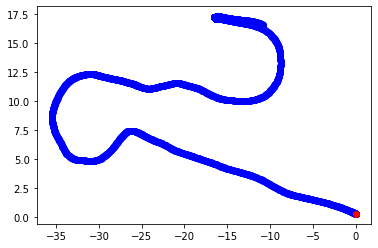

In [21]:
import matplotlib.pyplot as plt

wps = np.array([i[-1] for i in hist])
plt.scatter(wps[:,0], wps[:,1], c='b')
plt.scatter(wps[0,0], wps[0,1], c='r')

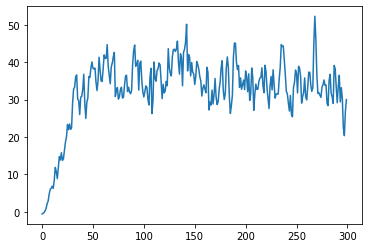

In [44]:
import matplotlib.pyplot as plt
import pickle 

with open('checkpoints/race_v1.1_r', 'rb') as f:
    rs = pickle.load(f)
    
plt.plot(rs)

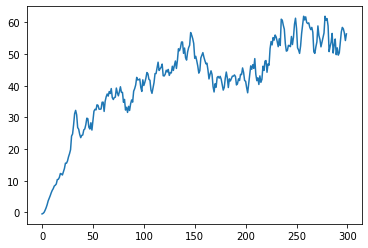

In [4]:
import matplotlib.pyplot as plt
import pickle 

with open('checkpoints/v1.2_r', 'rb') as f:
    rs = pickle.load(f)
    
plt.plot(rs)

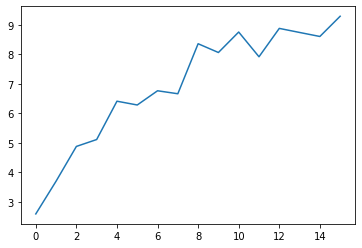

In [50]:
import matplotlib.pyplot as plt
import pickle 

with open('../checkpoints/race_v1.0.0_er', 'rb') as f:
    rs = pickle.load(f)
    
plt.plot(rs)


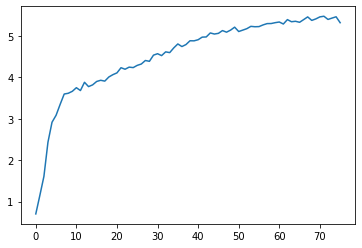

In [51]:
import matplotlib.pyplot as plt
import pickle 

with open('../checkpoints/race_v1.0.0_r', 'rb') as f:
    rs = pickle.load(f)
    
plt.plot(rs)
